# Overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import spacy
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date
from catboost import Pool, CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import holidays
from itertools import product
from xgboost import plot_importance


rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
item_categories = pd.read_csv("./data/item_categories.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [7]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



# Preprocessing

## train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


### Format: date

In [3]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [4]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [5]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

### Date aggregation

In [6]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [7]:
zeros = []
for i in range(34):
    sales = train_g[train_g['date_block_num']==i]
    zeros.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
zeros = pd.DataFrame(np.vstack(zeros), columns=['date_block_num','shop_id','item_id'])

train_g = zeros.merge(train_g, on=['date_block_num', 'shop_id', 'item_id'], how="left")
train_g = train_g.fillna(0)
train_g

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
10913845,33,59,5662,1.0
10913846,33,59,10068,1.0
10913847,33,59,12839,1.0
10913848,33,59,18275,1.0


## test

In [20]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")

The number of shops in train data: 60
The number of shops in test data: 42


In [21]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


363

## shop

According to discussion in kaggle, some shops are similar to each other possibly due to re-opening. 

In [8]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

# Feature Engineering

## Text Embeddings

In [10]:
ru_model = KeyedVectors.load_word2vec_format('../wiki.ru.vec')

In [11]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features

In [12]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

### item_categories

In [13]:
item_categories_feature = extract_feature(item_categories['item_category_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 272.54it/s]

Max: 1800
Failed: 1


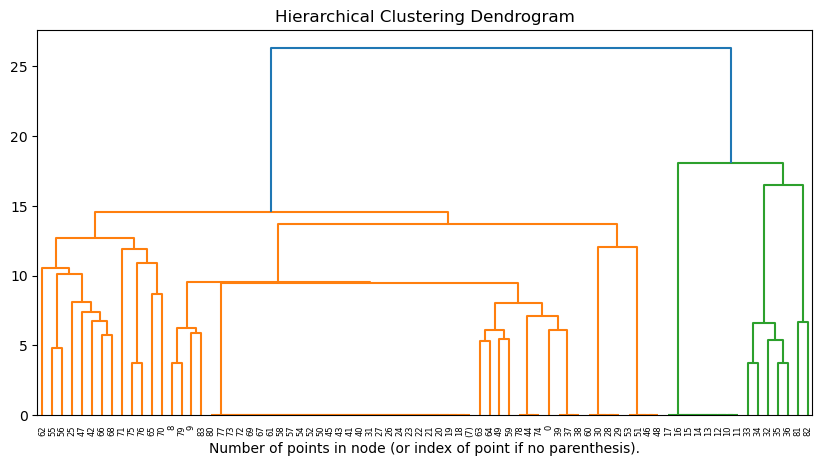

In [14]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(item_categories_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [15]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 17
Check the shape of labels: 84
Labels: [ 2  6  6  6  6  6  6  6  5  5 11 11 11 11 11 11 11 11  6  6  6  6  6  6
  6 15  6  6 16 16 16  6  3  3  3  3  3  2  2  2  6  6  0  6  2  6  9  0
  9  7  6  9  6  9  6 12 12  6  6  7 16  6 10  7  7 14  0  6  0  6 13  8
  6  6  2  4  4  6  2  5  6  1  1  5]


In [16]:
item_categories['item_category_te'] = clustering.labels_
item_categories = item_categories.drop(columns=['item_category_name'])
item_categories

,item_category_id,item_category_te
0,0,2
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
79,79,5
80,80,6
81,81,1
82,82,1


In [17]:
cols = ["category_1", "category_2"]
item_categories_tfidf = pd.read_csv("./sales/_item_categories.csv", 
                                    usecols=["item_category_id", "category_1", "category_2"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(item_categories_tfidf[col].unique()))
    item_categories_tfidf = item_categories_tfidf.replace({col:value_map})

item_categories_tfidf.head()

,item_category_id,category_1,category_2
0,0,0,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


### shops

In [18]:
shops_feature = extract_feature(shops['shop_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 167.43it/s]

Max: 1500
Failed: 2


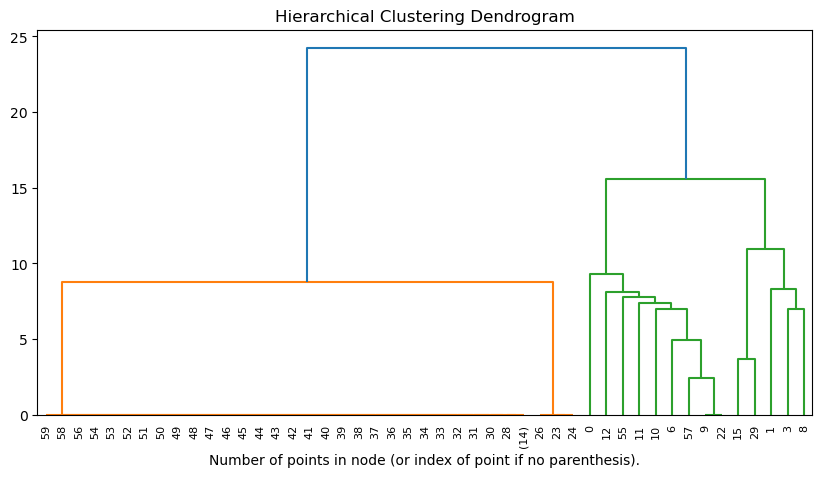

In [19]:
clustering = AgglomerativeClustering(distance_threshold=5, n_clusters=None).fit(shops_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [20]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 12
Check the shape of labels: 60
Labels: [ 9  6  5 11  5  5  0  5  8  0 10  4  7  5  5  1  5  5  5  5  5  5  0  2
  2  5  2  5  5  1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  3  5  0  5  5]


In [21]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [22]:
shops['city'] = encoding_cate(shop_city, 0)
shops['info'] = encoding_cate(shop_info, 1)
shops['shop_te'] = clustering.labels_
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 32
The number of classes: 7


,shop_id,city,info,shop_te
0,0,30,2,9
1,1,30,6,6
2,2,10,6,5
3,3,2,4,11
4,4,3,6,5


In [23]:
cols = ["shop_kind", "city", "shop_brand"]
shops_tfidf = pd.read_csv("./sales/_shops.csv", usecols=["shop_id", "shop_kind", "city", "shop_brand"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(shops_tfidf[col].unique()))
    shops_tfidf = shops_tfidf.replace({col:value_map})

shops_tfidf = shops_tfidf.rename(columns={'city': 'city2'})
shops_tfidf.head()

,shop_id,city2,shop_kind,shop_brand
0,0,0,0,0
1,1,0,1,1
2,2,1,1,2
3,3,2,2,3
4,4,3,1,4


### items

In [24]:
# The first word in item name
first_word = items['item_name'].str.split(pat=' ').apply(lambda x: x[0])
first_word = encoding_cate(first_word, 3)

The number of classes: 1224


In [25]:
# Information about the item in ()
def trans_lst(col):
    if len(col) > 0:
        item = col[0]
        item = item.lower()
        item = re.sub("\s", "", item)
        item = item.strip("\[\s\t\n")
    else:
        item = ""
    return item

item_addons = items['item_name'].str.findall(r'\((.+?)\)').apply(trans_lst)
item_addons = encoding_cate(item_addons, 5)

The number of classes: 116


In [26]:
# Information about the item in []
item_addons_2 = items['item_name'].str.findall(r'\[(.+?)[,\]...]').apply(trans_lst)
item_addons_2 = encoding_cate(item_addons_2, 10)

The number of classes: 14


In [27]:
items['first_word'] = first_word
items['item_addons'] = item_addons
items['item_addons_2'] = item_addons_2
items = items.drop(columns=['item_name'])
items

,item_id,item_category_id,first_word,item_addons,item_addons_2
0,0,40,0,0,13
1,1,76,0,115,12
2,2,40,0,0,13
3,3,40,0,0,13
4,4,40,0,38,13
...,...,...,...,...,...
22165,22165,31,0,115,12
22166,22166,54,0,115,9
22167,22167,49,0,81,13
22168,22168,62,0,115,13


In [27]:
items_tfidf = pd.read_csv("./sales/items.csv")[['item_id', 'item_name']]
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_name_tfidf = pd.DataFrame(tfidf.fit_transform(items_tfidf['item_name']).toarray())
for i in range(feature_count):
    feature_name = 'item_name_tfidf_' + str(i)
    items_tfidf[feature_name] = items_name_tfidf[items_name_tfidf.columns[i]]
items_tfidf.drop('item_name', axis = 1, inplace = True)
items_tfidf = items_tfidf.merge(items_tfidf, on = 'item_id', how = 'left')

## Structural Embeddings

### Date

In [9]:
holiday = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().apply(lambda x: int(x in holidays.Russia()))
holiday = holiday.to_frame('check').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(holiday['index'].dt.year.unique().tolist(), 
                                holiday['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]

holiday['date_block_num'] = holiday['index'].apply(map_date_block_num)
holiday = holiday.groupby(by='date_block_num')['check'].sum().to_frame('n_holidays').reset_index()

In [10]:
day_of_week = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().dt.isocalendar().day.to_frame('day').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(day_of_week['index'].dt.year.unique().tolist(), 
                                day_of_week['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]
day_of_week['date_block_num'] = day_of_week['index'].apply(map_date_block_num)
for i in range(1, 8):
    day_of_week[f'day_{i}'] = (day_of_week['day'] == i).astype(int)
    
day_of_week = day_of_week.drop(columns=['index', 'day']).groupby(by=['date_block_num']).sum().reset_index()

In [11]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['daysinmonth'] = train['date'].dt.daysinmonth
train['is_busday'] = np.is_busday(train['date'].dt.date.tolist()).astype(int)
train_busdays = train.loc[:, ['date', 'date_block_num', 'is_busday']].drop_duplicates()
train = train.merge(train_busdays.groupby(by=['date_block_num'])['is_busday'].sum().to_frame('n_busdays'),
                    on='date_block_num',
                    how='left')
date_meta = train.drop(columns=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'is_busday'])
date_meta = date_meta.drop_duplicates()

In [12]:
train_g = train_g.merge(holiday, on='date_block_num', how='left')
train_g = train_g.merge(day_of_week, on='date_block_num', how='left')
train_g = train_g.merge(date_meta, on=['date_block_num'], how='left')
train_g

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,year,month,quarter,daysinmonth,n_busdays
0,0,0,32,6.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
1,0,0,33,3.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
2,0,0,35,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
3,0,0,43,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
4,0,0,51,2.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,33,59,5662,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
10913846,33,59,10068,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
10913847,33,59,12839,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
10913848,33,59,18275,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22


In [13]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test['quarter'] = 4
test['daysinmonth'] = 30
test['n_busdays'] = np.busday_count('2015-11', '2015-12')
test = test.merge(holiday, on='date_block_num', how='left')
test = test.merge(day_of_week, on='date_block_num', how='left')
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,0,5,5037,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
1,1,5,5320,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
2,2,5,5233,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
3,3,5,5232,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
4,4,5,5268,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214196,214196,45,16188,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214197,214197,45,15757,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214198,214198,45,19648,34,2015,11,4,30,21,1,5,4,4,4,4,4,5


### Price

In [14]:
# price median
price_med = train.loc[:, ['item_id', 'item_price']].groupby(by=['item_id']).median().reset_index()
price_med = price_med.rename(columns={'item_price': 'item_price_med'})
train = train_g.merge(price_med, on='item_id', how='left')
test = test.merge(price_med, on='item_id', how='left')

In [15]:
# price date median
price_med_date = train.loc[:, ['date_block_num', 'item_id', 'item_price_med']]
price_med_date = price_med_date.groupby(by=['date_block_num', 'item_id']).median().reset_index()
price_med_date = price_med_date.rename(columns={'item_price_med': 'item_price_med_date'})
train = train_g.merge(price_med_date, on=['date_block_num', 'item_id'], how='left')
test = test.merge(price_med_date, on=['date_block_num', 'item_id'], how='left')

In [16]:
# price-item lag
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_price_med_date']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_id']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_price_med_date': f'item_price_med_date_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [17]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,daysinmonth,n_busdays,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12
0,0,0,32,6.0,8,4,5,5,5,4,...,31,23,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,8,4,5,5,5,4,...,31,23,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,8,4,5,5,5,4,...,31,23,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,8,4,5,5,5,4,...,31,23,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,8,4,5,5,5,4,...,31,23,249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,33,59,5662,1.0,0,4,4,4,5,5,...,31,22,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0
10913846,33,59,10068,1.0,0,4,4,4,5,5,...,31,22,149.0,NaN,NaN,NaN,NaN,NaN,NaN,149.0
10913847,33,59,12839,1.0,0,4,4,4,5,5,...,31,22,149.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0
10913848,33,59,18275,1.0,0,4,4,4,5,5,...,31,22,199.0,199.0,NaN,199.0,199.0,199.0,199.0,199.0


In [18]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,day_7,item_price_med,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12
0,0,5,5037,34,2015,11,4,30,21,1,...,5,1999.0,NaN,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0
1,1,5,5320,34,2015,11,4,30,21,1,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,2015,11,4,30,21,1,...,5,599.5,NaN,599.5,599.5,599.5,599.5,599.5,599.5,NaN
3,3,5,5232,34,2015,11,4,30,21,1,...,5,599.5,NaN,599.5,599.5,599.5,NaN,NaN,NaN,NaN
4,4,5,5268,34,2015,11,4,30,21,1,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,5,199.0,NaN,199.0,199.0,199.0,199.0,199.0,199.0,NaN
214196,214196,45,16188,34,2015,11,4,30,21,1,...,5,1223.0,NaN,1223.0,1223.0,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,34,2015,11,4,30,21,1,...,5,199.0,NaN,199.0,199.0,199.0,199.0,199.0,199.0,199.0
214198,214198,45,19648,34,2015,11,4,30,21,1,...,5,99.0,NaN,99.0,99.0,99.0,99.0,99.0,99.0,NaN


### Release Date

In [17]:
release = pd.concat([train_g.loc[:, ['date_block_num', 'item_id']],
                    test.loc[:, ['date_block_num', 'item_id']]])
release = release.groupby(by=['item_id']).min().reset_index()
release = release.rename(columns={'date_block_num': 'release_date'})
train = train.merge(release, on='item_id', how='left')
test = test.merge(release, on='item_id', how='left')

In [20]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,n_busdays,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12,release_date
0,0,0,32,6.0,8,4,5,5,5,4,...,23,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,0,33,3.0,8,4,5,5,5,4,...,23,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,0,35,1.0,8,4,5,5,5,4,...,23,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,0,43,1.0,8,4,5,5,5,4,...,23,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,0,51,2.0,8,4,5,5,5,4,...,23,249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,33,59,5662,1.0,0,4,4,4,5,5,...,22,549.0,549.0,549.0,549.0,549.0,549.0,549.0,549.0,21
10913846,33,59,10068,1.0,0,4,4,4,5,5,...,22,149.0,NaN,NaN,NaN,NaN,NaN,NaN,149.0,1
10913847,33,59,12839,1.0,0,4,4,4,5,5,...,22,149.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0,0
10913848,33,59,18275,1.0,0,4,4,4,5,5,...,22,199.0,199.0,NaN,199.0,199.0,199.0,199.0,199.0,17


In [21]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,item_price_med,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12,release_date
0,0,5,5037,34,2015,11,4,30,21,1,...,1999.0,NaN,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,20
1,1,5,5320,34,2015,11,4,30,21,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
2,2,5,5233,34,2015,11,4,30,21,1,...,599.5,NaN,599.5,599.5,599.5,599.5,599.5,599.5,NaN,27
3,3,5,5232,34,2015,11,4,30,21,1,...,599.5,NaN,599.5,599.5,599.5,NaN,NaN,NaN,NaN,31
4,4,5,5268,34,2015,11,4,30,21,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,199.0,NaN,199.0,199.0,199.0,199.0,199.0,199.0,NaN,23
214196,214196,45,16188,34,2015,11,4,30,21,1,...,1223.0,NaN,1223.0,1223.0,NaN,NaN,NaN,NaN,NaN,32
214197,214197,45,15757,34,2015,11,4,30,21,1,...,199.0,NaN,199.0,199.0,199.0,199.0,199.0,199.0,199.0,0
214198,214198,45,19648,34,2015,11,4,30,21,1,...,99.0,NaN,99.0,99.0,99.0,99.0,99.0,99.0,NaN,23


### Sales Lag

In [19]:
# item sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'item_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'item_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'item_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'item_id'], how='left')

In [20]:
# Merge
train = train.merge(items, on='item_id', how='left')
test = test.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(item_categories, on='item_category_id', how='left')
train = train.merge(item_categories_tfidf, on='item_category_id', how='left')
test = test.merge(item_categories_tfidf, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
train = train.merge(shops_tfidf, on='shop_id', how='left')
test = test.merge(shops_tfidf, on='shop_id', how='left')
train = train.merge(items_tfidf, on='item_id', how='left')
test = test.merge(items_tfidf, on='item_id', how='left')

In [3]:
# item-shop mean
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_id']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'item_shop_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [4]:
# shop sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'shop_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id'], how='left')

In [5]:
# city sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'city', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'city']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'city_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'city'], how='left')
    test = test.merge(sales, on=['date_block_num', 'city'], how='left')

In [6]:
# category sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'item_category_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'item_category_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'item_category_id_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'item_category_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'item_category_id'], how='left')

In [7]:
# shop category mean
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_category_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_category_id']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'shop_cat_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

In [8]:
# shop category_te mean
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_category_te', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_category_te']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'shop_cat_te_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_category_te'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_category_te'], how='left')

In [9]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,shop_cat_sales_lag5,shop_cat_sales_lag6,shop_cat_sales_lag12,shop_cat_te_sales_lag1,shop_cat_te_sales_lag2,shop_cat_te_sales_lag3,shop_cat_te_sales_lag4,shop_cat_te_sales_lag5,shop_cat_te_sales_lag6,shop_cat_te_sales_lag12
0,0,0,32,6.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,33,59,5662,1.0,0,4,4,4,5,5,...,0.260870,0.250000,0.772727,0.147418,0.172585,0.125171,0.132628,0.140345,0.118294,0.134632
10913846,33,59,10068,1.0,0,4,4,4,5,5,...,0.043222,0.128458,0.090782,0.106422,0.111888,0.087928,0.094901,0.041667,0.109859,0.081420
10913847,33,59,12839,1.0,0,4,4,4,5,5,...,0.140351,0.140657,0.120072,0.147418,0.172585,0.125171,0.132628,0.140345,0.118294,0.134632
10913848,33,59,18275,1.0,0,4,4,4,5,5,...,0.157593,0.147059,0.130277,0.099554,0.122271,0.144828,0.120739,0.152355,0.142091,0.123570


In [10]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,shop_cat_sales_lag5,shop_cat_sales_lag6,shop_cat_sales_lag12,shop_cat_te_sales_lag1,shop_cat_te_sales_lag2,shop_cat_te_sales_lag3,shop_cat_te_sales_lag4,shop_cat_te_sales_lag5,shop_cat_te_sales_lag6,shop_cat_te_sales_lag12
0,0,5,5037,34,2015,11,4,30,21,1,...,0.432927,0.438596,0.392857,0.151136,0.181133,0.225852,0.153899,0.147443,0.154414,0.189065
1,1,5,5320,34,2015,11,4,30,21,1,...,0.170370,0.154728,0.167089,0.154950,0.130758,0.209607,0.162759,0.166193,0.153740,0.159613
2,2,5,5233,34,2015,11,4,30,21,1,...,0.432927,0.438596,0.392857,0.151136,0.181133,0.225852,0.153899,0.147443,0.154414,0.189065
3,3,5,5232,34,2015,11,4,30,21,1,...,0.360000,0.340000,0.503185,0.151136,0.181133,0.225852,0.153899,0.147443,0.154414,0.189065
4,4,5,5268,34,2015,11,4,30,21,1,...,0.535354,0.895833,2.318841,0.151136,0.181133,0.225852,0.153899,0.147443,0.154414,0.189065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,0.090370,0.127507,0.156962,0.126255,0.072808,0.104803,0.126897,0.092330,0.127424,0.160822
214196,214196,45,16188,34,2015,11,4,30,21,1,...,0.107843,0.101010,0.207792,0.108187,0.097484,0.155063,0.189711,0.071197,0.068627,0.173145
214197,214197,45,15757,34,2015,11,4,30,21,1,...,0.090370,0.127507,0.156962,0.126255,0.072808,0.104803,0.126897,0.092330,0.127424,0.160822
214198,214198,45,19648,34,2015,11,4,30,21,1,...,0.068765,0.082237,0.114490,0.090550,0.120158,0.109375,0.086525,0.095591,0.107281,0.155396


In [11]:
# Check missing values
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

train:
date_block_num                   0
shop_id                          0
item_id                          0
item_cnt_month                   0
n_holidays                       0
                            ...   
shop_cat_te_sales_lag3     1392492
shop_cat_te_sales_lag4     1824706
shop_cat_te_sales_lag5     2249408
shop_cat_te_sales_lag6     2668370
shop_cat_te_sales_lag12    5051577
Length: 113, dtype: int64

test:
ID                             0
shop_id                        0
item_id                        0
date_block_num                 0
year                           0
                           ...  
shop_cat_te_sales_lag3     10200
shop_cat_te_sales_lag4     10200
shop_cat_te_sales_lag5     10200
shop_cat_te_sales_lag6     10200
shop_cat_te_sales_lag12    16640
Length: 114, dtype: int64



In [12]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [13]:
# Prepare train/test data
train_y = train['item_cnt_month'].clip(0, 20)
train = train.drop(columns=['item_cnt_month'])
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 112 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    date_block_num                int16  
 1    shop_id                       int16  
 2    item_id                       int16  
 3    n_holidays                    int64  
 4    day_1                         int64  
 5    day_2                         int64  
 6    day_3                         int64  
 7    day_4                         int64  
 8    day_5                         int64  
 9    day_6                         int64  
 10   day_7                         int64  
 11   year                          int64  
 12   month                         int64  
 13   quarter                       int64  
 14   daysinmonth                   int64  
 15   n_busdays                     int64  
 16   item_price_med_date           float64
 17   item_price_med_date_lag1      float64
 18 

In [14]:
test = test.drop(columns=['ID'])
test = test[train.columns.tolist()]
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 112 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    date_block_num                int64  
 1    shop_id                       int64  
 2    item_id                       int64  
 3    n_holidays                    int64  
 4    day_1                         int64  
 5    day_2                         int64  
 6    day_3                         int64  
 7    day_4                         int64  
 8    day_5                         int64  
 9    day_6                         int64  
 10   day_7                         int64  
 11   year                          int64  
 12   month                         int64  
 13   quarter                       int64  
 14   daysinmonth                   int64  
 15   n_busdays                     int64  
 16   item_price_med_date           float64
 17   item_price_med_date_lag1      float64
 18   it

In [15]:
train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")
train_y.to_pickle("./data/train_y.pkl")

# Models

## ARIMA

### Example

In [15]:
trial = train.groupby(by=["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame(name='item_cnt_month').reset_index()
trial = trial.set_index('date_block_num')
trial

,shop_id,item_cnt_month
date_block_num,,
0,2,1151.0
0,3,767.0
0,4,2117.0
0,6,3699.0
0,7,2498.0
...,...,...
33,55,1972.0
33,56,1267.0
33,57,2319.0


In [34]:
# Auto ARIMA：Example
trial_ex = trial[trial['shop_id'] == 2].drop(columns=['shop_id'])
model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -232.960
Date:                Mon, 28 Nov 2022   AIC                            471.921
Time:                        23:34:17   BIC                            476.500
Sample:                             0   HQIC                           473.482
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    636.9515    194.972      3.267      0.001     254.813    1019.090
ar.L1          0.2947      0.184      1.601      0.109      -0.066       0.656
sigma2        5.2e+04   8361.650      6.219      0.000    3.56e+04    6.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                80.69
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.89
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

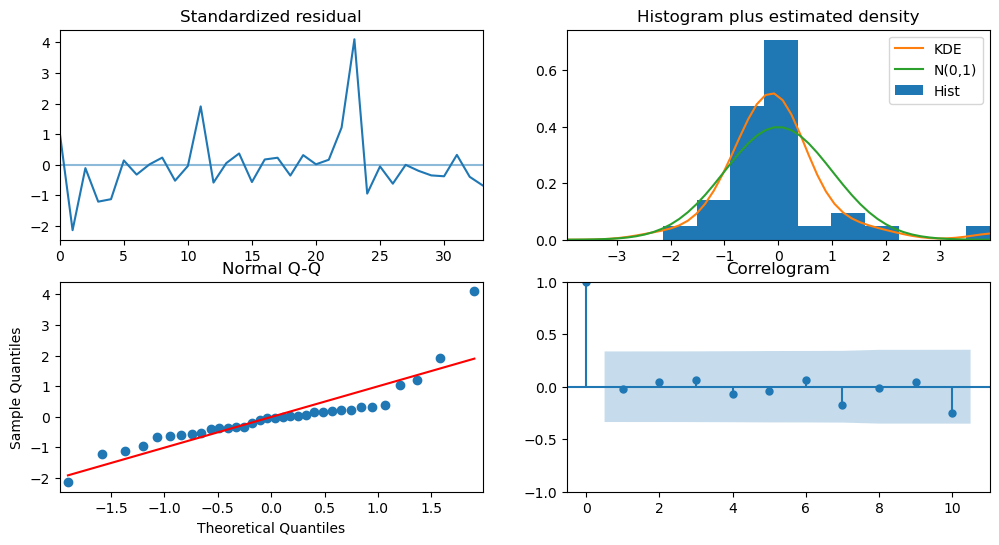

In [35]:
with plt.rc_context():
    plt.rc("figure", figsize=(12, 6))
    model.plot_diagnostics()
    plt.show()

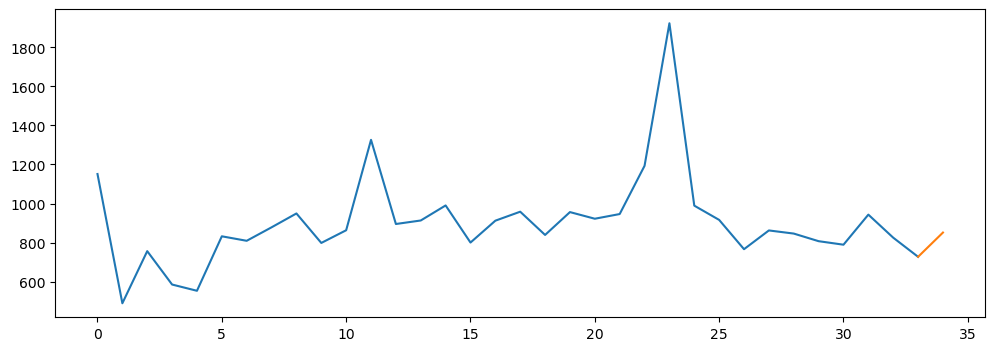

In [50]:
forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))

with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(trial_ex.shape[0]), trial_ex['item_cnt_month'])
    plt.plot(range(trial_ex.shape[0] - 1, trial_ex.shape[0] + 34 - trial_ex.index[-1]), 
             [trial_ex['item_cnt_month'].iloc[-1], forecast.iloc[-1]])
    plt.show()

### Prediction

In [31]:
shop_lst = train['shop_id'].unique().tolist()
train_origin = pd.read_csv("./data/sales_train.csv")
per = train_origin.groupby(by=["item_id"])["item_cnt_day"].sum().to_frame(name='item_cnt').reset_index()
col = per["item_cnt"].copy()
per["item_per"] = col / col.sum()
pre_df  = pd.DataFrame(columns=["shop_id", "item_id", "item_cnt_month"])

for i in range(len(shop_lst)):
    trial_ex = trial[trial['shop_id'] == shop_lst[i]].drop(columns=['shop_id'])
    model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
    forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))
    try:
        forecast = forecast.iloc[-1]
    except:
        forecast = trial_ex.iloc[0, -1]
    per_example = per[per['item_id'].isin(test.loc[(test['shop_id'] == shop_lst[i]), 'item_id'].unique().tolist())]
    per_example['item_cnt_month'] = per_example['item_per'] * forecast
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] > 20, 20, per_example['item_cnt_month'])
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] < 0, 0, per_example['item_cnt_month'])
    per_example['shop_id'] = shop_lst[i]
    per_example = per_example.drop(columns=["item_per", "item_cnt"])
    pre_df = pd.concat([pre_df, per_example], axis=0)
    
pre_df

/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

,shop_id,item_id,item_cnt_month
30,59,30,0.453507
31,59,31,0.311528
32,59,32,0.454159
33,59,33,0.181490
38,59,38,0.014328
...,...,...,...
21799,36,22162,0.063803
21800,36,22163,0.006846
21801,36,22164,0.045000
21803,36,22166,0.031765


In [35]:
test_arima = pd.merge(test, pre_df, on=['shop_id', 'item_id'], how = "left")
test_arima = test_arima.fillna(value=test_arima['item_cnt_month'].mean())
# test_arima = test_arima.fillna(0)
test_arima 

,ID,shop_id,item_id,item_category_id,date_block_num,price_m,item_cnt_month
0,0,5,5037,19,34,1499.000000,0.428533
1,1,5,5320,55,34,445.207669,0.000000
2,2,5,5233,19,34,1199.000000,0.171076
3,3,5,5232,23,34,1190.433333,0.047577
4,4,5,5268,20,34,445.207669,0.000000
...,...,...,...,...,...,...,...
214195,214195,45,18454,55,34,99.000000,0.087680
214196,214196,45,16188,64,34,1359.000000,0.000678
214197,214197,45,15757,55,34,229.000000,0.062750
214198,214198,45,19648,40,34,89.100000,0.009497


In [36]:
test_arima.isna().sum()

ID                  0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
price_m             0
item_cnt_month      0
dtype: int64

In [37]:
test_arima = test_arima.loc[:, ['ID', 'item_cnt_month']]
test_arima.to_csv('./results/submission_4.csv', index=False)

## Model Blending

In [2]:
train = pd.read_pickle("./data/train.pkl")
test = pd.read_pickle("./data/test.pkl")
train_y = pd.read_pickle("./data/train_y.pkl")

In [3]:
# Blending
class Blending():
    """Implement model blending strategy.
    
    Args:
        train: train data - features.
        train: train date - labels.
        test: test data - features.
    """
    def __init__(self, train, train_y, test):
        self.train = train
        self.train_y = train_y
        self.test = test
        self.create_models()
        
    def create_models(self):
        cat_model = CatBoostRegressor(early_stopping_rounds=10)
        xgb_model = xgb.XGBRegressor(n_estimators=5000, 
                                   max_depth=10, 
                                   early_stopping_rounds=10,
                                   eval_metric="rmse",
                                   learning_rate=0.1,
                                   subsample=0.5,
                                   colsample_bytree=0.5)
        self.model_dict = {'cat': [cat_model, [], []],
                           'xgb': [xgb_model, [], []]}
        self.meta_model = HistGradientBoostingRegressor(verbose=1)
        
    def level_1(self):
        print('Training base models...')
        def create_folds(num):
            X_tr = self.train[self.train['date_block_num'] < num]
            X_va = self.train[self.train['date_block_num'] == num]
            index = X_tr.shape[0]
            y_tr = self.train_y[:index]
            y_va = self.train_y[index:]
            return X_tr, X_va, y_tr, y_va
        
        X_tr, X_va, y_tr, y_va = create_folds(33)
        self.X_va = X_va
        self.y_va = y_va
        for model_key in list(self.model_dict.keys()):
            print(f'Progress: {model_key}.')
            model = self.model_dict[model_key]
            if model_key == 'cat':
                model[0].fit(X_tr, y_tr, early_stopping_rounds=10, eval_set=(X_va, y_va), use_best_model=True)
            else:
                model[0].fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=True)
            pred_va = model[0].predict(X_va)
            model[1].append(pred_va.tolist())
            pred_te = model[0].predict(self.test)
            model[2].append(pred_te.tolist())
    
    def level_2(self):
        def agg_features(num):
            preds_dict = dict()
            for model_key in list(self.model_dict.keys()):
                preds_dict[model_key] = self.model_dict[model_key][num][0]
            preds_df = pd.DataFrame(preds_dict)
            return preds_df
            
        print('Training meta model...')
        preds_df = agg_features(1)
        X_va = pd.concat([self.X_va.reset_index(drop=True), preds_df.reset_index(drop=True)], axis=1)
        self.meta_model.fit(X_va, self.y_va)
        
        print('Predicting...')
        preds_df = agg_features(2)
        X_te = pd.concat([self.test.reset_index(drop=True), preds_df.reset_index(drop=True)], axis=1)
        return self.meta_model.predict(X_te)
    
    def main(self):
        self.level_1()
        preds = self.level_2()
        return preds

In [4]:
model = Blending(train, train_y, test)
pred = model.main()

Training base models...
Progress: cat.
Learning rate set to 0.218451
0:	learn: 1.1418905	test: 1.0760845	best: 1.0760845 (0)	total: 658ms	remaining: 10m 57s
1:	learn: 1.0850704	test: 1.0338646	best: 1.0338646 (1)	total: 1.31s	remaining: 10m 55s
2:	learn: 1.0449908	test: 1.0053329	best: 1.0053329 (2)	total: 1.92s	remaining: 10m 37s
3:	learn: 1.0177377	test: 0.9870543	best: 0.9870543 (3)	total: 2.41s	remaining: 10m 1s
4:	learn: 0.9983204	test: 0.9756880	best: 0.9756880 (4)	total: 2.99s	remaining: 9m 55s
5:	learn: 0.9833504	test: 0.9629849	best: 0.9629849 (5)	total: 3.71s	remaining: 10m 14s
6:	learn: 0.9724616	test: 0.9561884	best: 0.9561884 (6)	total: 4.43s	remaining: 10m 28s
7:	learn: 0.9637717	test: 0.9496756	best: 0.9496756 (7)	total: 5.11s	remaining: 10m 33s
8:	learn: 0.9577782	test: 0.9471160	best: 0.9471160 (8)	total: 5.61s	remaining: 10m 17s
9:	learn: 0.9531577	test: 0.9458619	best: 0.9458619 (9)	total: 6.28s	remaining: 10m 21s
10:	learn: 0.9499742	test: 0.9436590	best: 0.9436590 

In [5]:
pred_df = pd.Series(pred).to_frame('item_cnt_month').reset_index()
pred_df = pred_df.rename(columns={'index': 'ID'})
pred_df['item_cnt_month'] = pred_df['item_cnt_month'].clip(0, 20)
pred_df

,ID,item_cnt_month
0,0,0.482017
1,1,0.217207
2,2,0.812677
3,3,0.328142
4,4,1.437171
...,...,...
214195,214195,0.071202
214196,214196,0.047816
214197,214197,0.053532
214198,214198,0.032442


In [6]:
pred_df.to_csv('./submission_blending.csv', index=False)

## XGBoost

In [9]:
X_tr = train[train['date_block_num'] < 33]
X_va = train[train['date_block_num'] == 33]
index = X_tr.shape[0]
y_tr = train_y[:index]
y_va = train_y[index:]

In [4]:
# XGBoost
model = xgb.XGBRegressor(n_estimators=5000, 
                         max_depth=10, 
                         early_stopping_rounds=10,
                         eval_metric="rmse",
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree=0.5)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=True)
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

[0]	validation_0-rmse:1.18956	validation_1-rmse:1.11717
[1]	validation_0-rmse:1.14222	validation_1-rmse:1.07833
[2]	validation_0-rmse:1.10074	validation_1-rmse:1.04427
[3]	validation_0-rmse:1.06532	validation_1-rmse:1.01895
[4]	validation_0-rmse:1.03440	validation_1-rmse:0.99738
[5]	validation_0-rmse:1.00764	validation_1-rmse:0.97824
[6]	validation_0-rmse:0.98868	validation_1-rmse:0.96426
[7]	validation_0-rmse:0.96855	validation_1-rmse:0.95426
[8]	validation_0-rmse:0.94982	validation_1-rmse:0.94428
[9]	validation_0-rmse:0.93382	validation_1-rmse:0.93351
[10]	validation_0-rmse:0.92091	validation_1-rmse:0.92517
[11]	validation_0-rmse:0.91005	validation_1-rmse:0.91844
[12]	validation_0-rmse:0.90054	validation_1-rmse:0.91224
[13]	validation_0-rmse:0.89367	validation_1-rmse:0.90797
[14]	validation_0-rmse:0.88691	validation_1-rmse:0.90503
[15]	validation_0-rmse:0.87922	validation_1-rmse:0.90156
[16]	validation_0-rmse:0.87345	validation_1-rmse:0.89822
[17]	validation_0-rmse:0.86925	validation

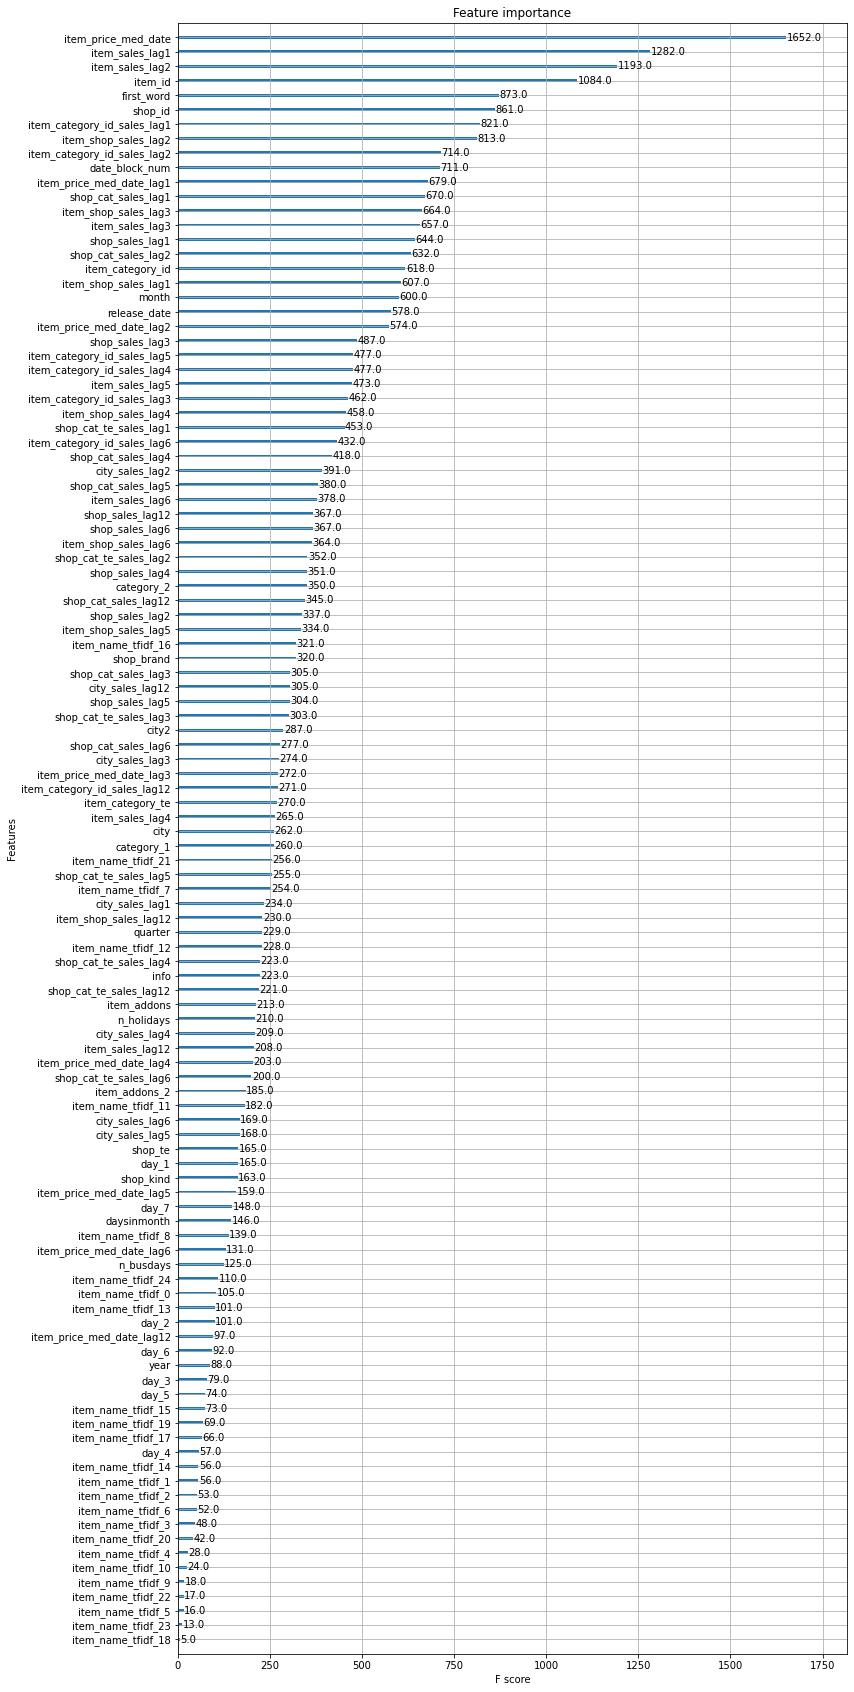

In [6]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (12, 30))
plt.show()

In [4]:
# XGBoost: Prediction
model = xgb.XGBRegressor(n_estimators=5000, 
                         max_depth=10, 
                         early_stopping_rounds=10,
                         eval_metric="rmse",
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree=0.5)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=True)
pred = model.predict(test)

[0]	validation_0-rmse:1.18956	validation_1-rmse:1.11717
[1]	validation_0-rmse:1.14222	validation_1-rmse:1.07833
[2]	validation_0-rmse:1.10074	validation_1-rmse:1.04427
[3]	validation_0-rmse:1.06532	validation_1-rmse:1.01895
[4]	validation_0-rmse:1.03440	validation_1-rmse:0.99738
[5]	validation_0-rmse:1.00764	validation_1-rmse:0.97824
[6]	validation_0-rmse:0.98868	validation_1-rmse:0.96426
[7]	validation_0-rmse:0.96855	validation_1-rmse:0.95426
[8]	validation_0-rmse:0.94982	validation_1-rmse:0.94428
[9]	validation_0-rmse:0.93382	validation_1-rmse:0.93351
[10]	validation_0-rmse:0.92091	validation_1-rmse:0.92517
[11]	validation_0-rmse:0.91005	validation_1-rmse:0.91844
[12]	validation_0-rmse:0.90054	validation_1-rmse:0.91224
[13]	validation_0-rmse:0.89367	validation_1-rmse:0.90797
[14]	validation_0-rmse:0.88691	validation_1-rmse:0.90503
[15]	validation_0-rmse:0.87922	validation_1-rmse:0.90156
[16]	validation_0-rmse:0.87345	validation_1-rmse:0.89822
[17]	validation_0-rmse:0.86925	validation

In [5]:
pred_df = pd.Series(pred).to_frame('item_cnt_month').reset_index()
pred_df = pred_df.rename(columns={'index': 'ID'})
pred_df['item_cnt_month'] = pred_df['item_cnt_month'].clip(0, 20)
pred_df

,ID,item_cnt_month
0,0,0.742575
1,1,0.200279
2,2,1.488425
3,3,0.445234
4,4,1.995686
...,...,...
214195,214195,0.128780
214196,214196,0.048488
214197,214197,0.046741
214198,214198,0.055763


In [6]:
pred_df.to_csv('./submission_xgb_new_2.csv', index=False)